In [21]:
import pandas as pd
import os
import torch
import gc
from transformers import AutoTokenizer, T5ForConditionalGeneration
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm, trange

In [22]:
df = pd.read_csv(os.path.join('data','parallel_corpus.csv'), index_col=0)

In [23]:
class PairsDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __getitem__(self, idx):
        assert idx < len(self.x['input_ids'])
        item = {key: val[idx] for key, val in self.x.items()}
        item['decoder_attention_mask'] = self.y['attention_mask'][idx]
        item['labels'] = self.y['input_ids'][idx]
        return item
    
    @property
    def n(self):
        return len(self.x['input_ids'])

    def __len__(self):
        return self.n # * 2

In [24]:
from typing import List, Dict, Union

class DataCollatorWithPadding:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        batch = self.tokenizer.pad(
            features,
            padding=True,
        )
        ybatch = self.tokenizer.pad(
            {'input_ids': batch['labels'], 'attention_mask': batch['decoder_attention_mask']},
            padding=True,
        ) 
        batch['labels'] = ybatch['input_ids']
        batch['decoder_attention_mask'] = ybatch['attention_mask']
        
        return {k: torch.tensor(v) for k, v in batch.items()}

In [25]:
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    
cleanup()

In [26]:
def evaluate_model(model, test_dataloader):
    num = 0
    den = 0

    for batch in test_dataloader:
        with torch.no_grad():
            loss = model(**{k: v.to(model.device) for k, v in batch.items()}).loss
            num += len(batch) * loss.item()
            den += len(batch)
    val_loss = num / den
    return val_loss

In [27]:
train_losses = []
val_losses = []
            
def train_loop(
    model, train_dataloader, val_dataloader, 
    max_epochs=30, 
    max_steps=1_000, 
    lr=3e-5,
    gradient_accumulation_steps=1, 
    cleanup_step=100,
    report_step=300,
    window=100,):

    cleanup()
    optimizer = torch.optim.Adam(params = [p for p in model.parameters() if p.requires_grad], lr=lr)

    ewm_loss = 0
    step = 0
    model.train()

    for epoch in trange(max_epochs):
        print(step, max_steps)
        if step >= max_steps:
            break
        tq = tqdm(train_dataloader)
        for i, batch in enumerate(tq):
            try:
                batch['labels'][batch['labels']==0] = -100
                loss = model(**{k: v.to(model.device) for k, v in batch.items()}).loss
                loss.backward()
            except Exception as e:
                print('error on step', i, e)
                loss = None
                cleanup()
                continue
            if i and i % gradient_accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()
                step += 1
                if step >= max_steps:
                    break

            if i % cleanup_step == 0:
                cleanup()

            w = 1 / min(i+1, window)
            ewm_loss = ewm_loss * (1-w) + loss.item() * w
            tq.set_description(f'loss: {ewm_loss:4.4f}')

            if (i and i % report_step == 0 or i == len(train_dataloader)-1)  and val_dataloader is not None:
                model.eval()
                eval_loss = evaluate_model(model, val_dataloader)
                model.train()
                print(f'epoch {epoch}, step {i}/{step}: train loss: {ewm_loss:4.4f}  val loss: {eval_loss:4.4f}')
                train_losses.append(ewm_loss)
                val_losses.append(eval_loss)
            # if step % 1000 == 0:
            #     model.save_pretrained(f't5_base_{dname}_{steps}')
        
    cleanup()

In [28]:
def train_model(x, y, model_name, test_size=0.1, batch_size=32, **kwargs):
    model = T5ForConditionalGeneration.from_pretrained(model_name).cuda()
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    x1, x2, y1, y2 = train_test_split(x, y, test_size=test_size, random_state=42)
    train_dataset = PairsDataset(tokenizer(x1), tokenizer(y1))
    test_dataset = PairsDataset(tokenizer(x2), tokenizer(y2))
    
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=False, shuffle=True, collate_fn=data_collator)
    val_dataloader = DataLoader(test_dataset, batch_size=batch_size, drop_last=False, shuffle=True, collate_fn=data_collator)

    train_loop(model, train_dataloader, val_dataloader, **kwargs)
    return model

In [29]:
model_name = "google-t5/t5-small"

In [30]:
cleanup()

In [31]:
datasets = {
    'train': df
}

In [32]:
for steps in [300, 1000, 3000, 10000]:
    for dname, d in datasets.items():
        print(f'\n\n\n  {dname}  {steps} \n=====================\n\n')
        model = train_model(d['line_destyled'].tolist(), d['line'].tolist(), model_name=model_name, batch_size=16, max_epochs=1000, max_steps=steps)
        model_path = os.path.join('model',f't5_small_{dname}_{steps}')
        model.save_pretrained(model_path)




  train  300 




  0%|          | 0/1000 [00:00<?, ?it/s]

0 300


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
  0%|          | 1/1000 [00:18<5:08:49, 18.55s/it]


300 300



  train  1000 




  0%|          | 0/1000 [00:00<?, ?it/s]

0 1000


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


epoch 0, step 300/300: train loss: 1.6784  val loss: 9.9124


epoch 0, step 600/600: train loss: 1.5130  val loss: 10.7436


epoch 0, step 900/900: train loss: 1.4187  val loss: 11.3156


  0%|          | 1/1000 [01:07<18:40:45, 67.31s/it]


1000 1000



  train  3000 




  0%|          | 0/1000 [00:00<?, ?it/s]

0 3000


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


epoch 0, step 300/300: train loss: 1.6608  val loss: 9.8692


epoch 0, step 600/600: train loss: 1.4968  val loss: 10.7146


epoch 0, step 900/900: train loss: 1.4303  val loss: 11.2515


  0%|          | 1/1000 [01:12<20:05:21, 72.39s/it]

epoch 0, step 1056/1056: train loss: 1.3969  val loss: 11.4321
1056 3000


epoch 1, step 300/1356: train loss: 1.3374  val loss: 11.6853


epoch 1, step 600/1656: train loss: 1.3034  val loss: 11.7986


epoch 1, step 900/1956: train loss: 1.2954  val loss: 11.7313


  0%|          | 2/1000 [02:25<20:07:24, 72.59s/it]

epoch 1, step 1056/2112: train loss: 1.2830  val loss: 12.2111
2112 3000


epoch 2, step 300/2412: train loss: 1.2468  val loss: 12.1620


epoch 2, step 600/2712: train loss: 1.2442  val loss: 12.2735


  0%|          | 3/1000 [03:24<18:51:19, 68.08s/it]


3000 3000



  train  10000 




  0%|          | 0/1000 [00:00<?, ?it/s]

0 10000


You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


epoch 0, step 300/300: train loss: 1.6471  val loss: 9.8976


epoch 0, step 600/600: train loss: 1.5013  val loss: 10.6652


epoch 0, step 900/900: train loss: 1.4252  val loss: 11.0569


  0%|          | 1/1000 [01:13<20:16:30, 73.06s/it]

epoch 0, step 1056/1056: train loss: 1.3884  val loss: 11.4904
1056 10000


epoch 1, step 300/1356: train loss: 1.3242  val loss: 11.5650


epoch 1, step 600/1656: train loss: 1.3164  val loss: 11.4975


epoch 1, step 900/1956: train loss: 1.2679  val loss: 11.9397


  0%|          | 2/1000 [02:26<20:16:30, 73.14s/it]

epoch 1, step 1056/2112: train loss: 1.2731  val loss: 12.0840
2112 10000


epoch 2, step 300/2412: train loss: 1.2434  val loss: 12.1304


epoch 2, step 600/2712: train loss: 1.2296  val loss: 12.0435


epoch 2, step 900/3012: train loss: 1.2168  val loss: 12.1124


  0%|          | 3/1000 [03:38<20:12:19, 72.96s/it]

epoch 2, step 1056/3168: train loss: 1.1827  val loss: 12.3040
3168 10000


epoch 3, step 300/3468: train loss: 1.1938  val loss: 12.4047


epoch 3, step 600/3768: train loss: 1.1740  val loss: 12.4127


epoch 3, step 900/4068: train loss: 1.1759  val loss: 12.2862


  0%|          | 4/1000 [04:52<20:14:18, 73.15s/it]

epoch 3, step 1056/4224: train loss: 1.1684  val loss: 12.0818
4224 10000


epoch 4, step 300/4524: train loss: 1.1507  val loss: 11.9990


epoch 4, step 600/4824: train loss: 1.1310  val loss: 12.2503


epoch 4, step 900/5124: train loss: 1.1302  val loss: 12.2070


  0%|          | 5/1000 [06:05<20:11:22, 73.05s/it]

epoch 4, step 1056/5280: train loss: 1.1323  val loss: 12.3508
5280 10000


epoch 5, step 300/5580: train loss: 1.1135  val loss: 12.4376


epoch 5, step 600/5880: train loss: 1.1155  val loss: 12.1849


epoch 5, step 900/6180: train loss: 1.1058  val loss: 12.2608


  1%|          | 6/1000 [07:19<20:14:44, 73.32s/it]

epoch 5, step 1056/6336: train loss: 1.0955  val loss: 12.1174
6336 10000


epoch 6, step 300/6636: train loss: 1.0850  val loss: 12.0809


epoch 6, step 600/6936: train loss: 1.0737  val loss: 12.0326


epoch 6, step 900/7236: train loss: 1.0812  val loss: 12.0698


  1%|          | 7/1000 [08:32<20:12:17, 73.25s/it]

epoch 6, step 1056/7392: train loss: 1.0668  val loss: 11.9927
7392 10000


epoch 7, step 300/7692: train loss: 1.0771  val loss: 11.8746


epoch 7, step 600/7992: train loss: 1.0572  val loss: 11.9032


epoch 7, step 900/8292: train loss: 1.0353  val loss: 11.9774


  1%|          | 8/1000 [09:45<20:09:39, 73.16s/it]

epoch 7, step 1056/8448: train loss: 1.0399  val loss: 11.8529
8448 10000


epoch 8, step 300/8748: train loss: 1.0438  val loss: 11.9739


epoch 8, step 600/9048: train loss: 1.0380  val loss: 12.0776



loss: 1.0401:  85%|████████▌ | 903/1057 [01:01<00:43,  3.55it/s]

epoch 8, step 900/9348: train loss: 1.0394  val loss: 12.0430


  1%|          | 9/1000 [10:58<20:08:46, 73.19s/it]

epoch 8, step 1056/9504: train loss: 1.0314  val loss: 12.0204
9504 10000


epoch 9, step 300/9804: train loss: 1.0197  val loss: 11.9405


  1%|          | 10/1000 [11:31<19:00:19, 69.11s/it]


10000 10000


In [37]:
# Подгрузим один из обученных нами чекпоинтов
base_model_name = 'google-t5/t5-small'
model_name = 'model/t5_small_train_3000'

In [38]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name).cuda()

In [39]:
def paraphrase(text, model, n=None, max_length='auto', temperature=0.0, beams=3):
    texts = [text] if isinstance(text, str) else text
    inputs = tokenizer(texts, return_tensors='pt', padding=True)['input_ids'].to(model.device)
    if max_length == 'auto':
        max_length = int(inputs.shape[1] * 1.2) + 10
    result = model.generate(
        inputs, 
        num_return_sequences=n or 1, 
        do_sample=False, 
        temperature=temperature, 
        repetition_penalty=3.0, 
        max_length=max_length,
        bad_words_ids=[[2]],  # unk
        num_beams=beams,
    )
    texts = [tokenizer.decode(r, skip_special_tokens=True) for r in result]
    if not n and isinstance(text, str):
        return texts[0]
    return texts

In [40]:
print(paraphrase(["Is this your genius method?"], model, temperature=50.0, beams=10))

['Is that your genius method?']


/home/danil/Projects/nlp_hw2/.venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:410: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `50.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


In [ ]:
# одно слово заменено синонимом, значит в принципе работает

In [ ]:
# train_losses
# val_losses

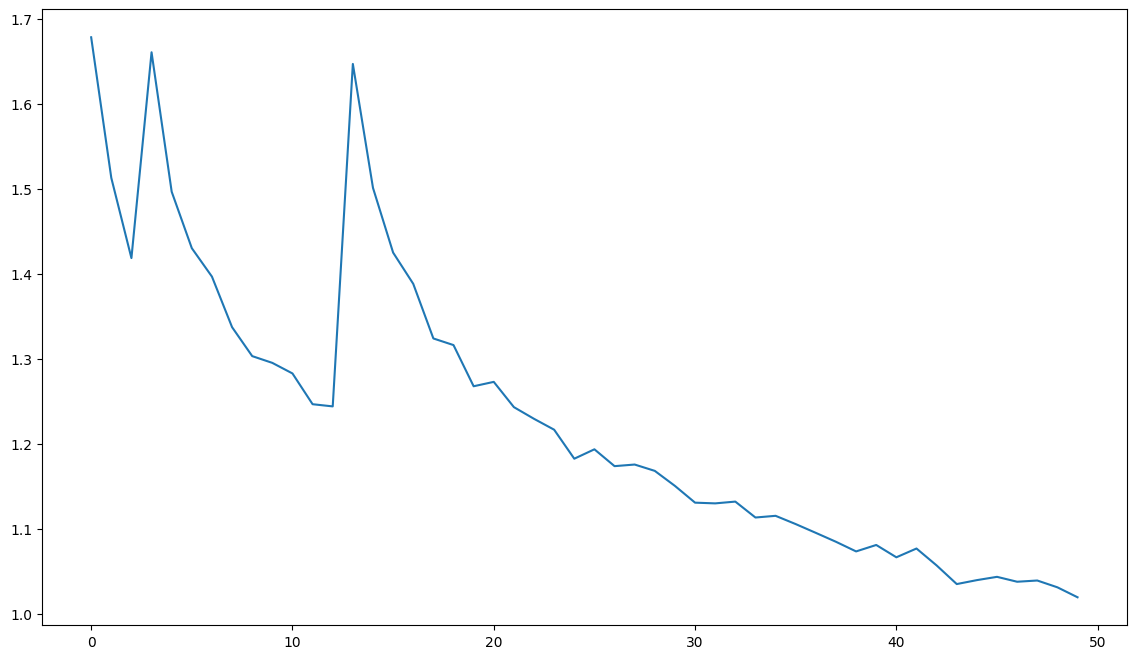

In [35]:
import matplotlib.pyplot as plt

fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(train_losses)), train_losses)

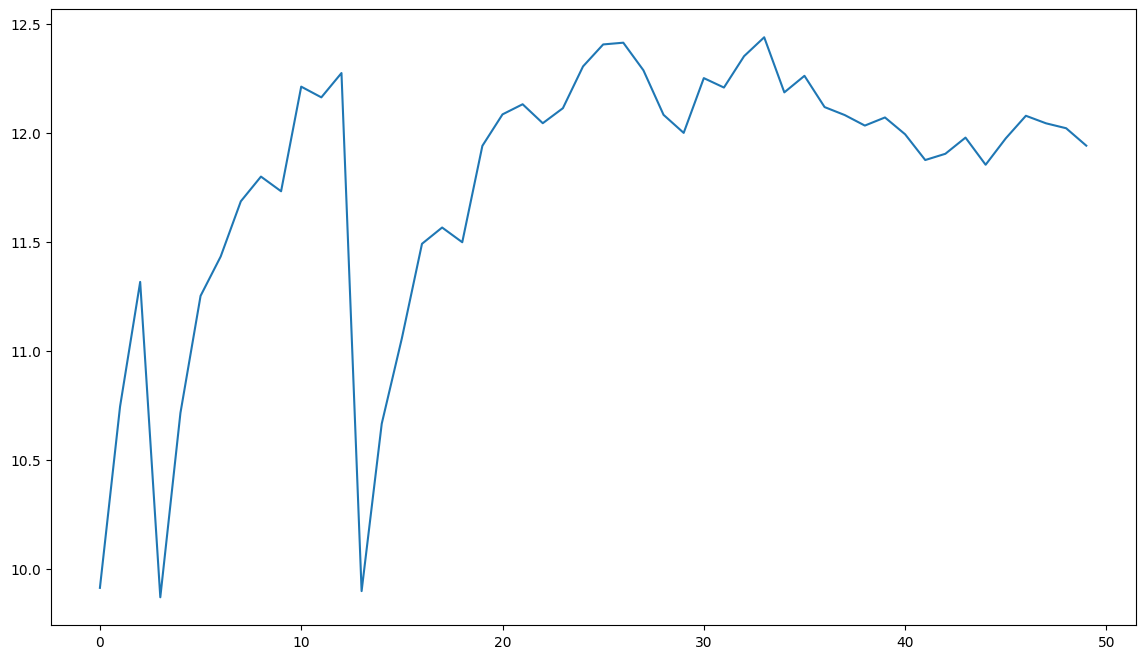

In [36]:
fix, ax = plt.subplots(figsize=(14, 8))
ax.plot(range(len(val_losses)), val_losses)

In [ ]:
# Судя по графикам, модель переобучилась
# TODO разобраться почему